## Importing and pre-processing

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

In [3]:
data = pd.read_csv('startups_data_cleaned_step1.csv')
df = data.copy()
print(df.columns)

date_columns = ['founded_at', 'first_funding_at', 'last_funding_at']
for col in date_columns:
    df[col] = pd.to_datetime(df[col])

Index(['name', 'market', 'funding_total_usd', 'country_code', 'state_code',
       'region', 'city', 'funding_rounds', 'founded_at', 'founded_month',
       'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'seed', 'venture', 'equity_crowdfunding',
       'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'post_ipo_equity', 'post_ipo_debt',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H',
       'category_count', 'clean_name', 'is_operating', 'category_updated'],
      dtype='object')


In [5]:
# Create temporal features
df['days_to_first_funding'] = (df['first_funding_at'] - df['founded_at']).dt.days
df['funding_duration'] = (df['last_funding_at'] - df['first_funding_at']).dt.days
df['company_age'] = (pd.Timestamp('2024-01-01') - df['founded_at']).dt.days
df['days_to_first_funding'] = df['days_to_first_funding'].fillna(-1)
df['funding_duration'] = df['funding_duration'].fillna(0)
df['company_age'] = df['company_age'].fillna(-1)
df['early_stage_funding'] = df['seed'] + df['angel']
df['growth_stage_funding'] = df['round_A'] + df['round_B']
df['late_stage_funding'] = df['round_C'] + df['round_D']

In [7]:
df_subset = df[[
    'funding_total_usd',
    'state_code',
    'funding_rounds',
    'days_to_first_funding',
    'funding_duration',
    'company_age',
    'category_updated',
    'is_operating'
]]

## Training & Evaluating the Decision Tree

Accuracy: 0.8010

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.40      0.40       403
           1       0.88      0.88      0.88      2059

    accuracy                           0.80      2462
   macro avg       0.64      0.64      0.64      2462
weighted avg       0.80      0.80      0.80      2462


Confusion Matrix:
[[ 163  240]
 [ 250 1809]]
True Positive Rate (TPR): 0.8786
False Positive Rate (FPR): 0.5955
ROC AUC Score: 0.6415


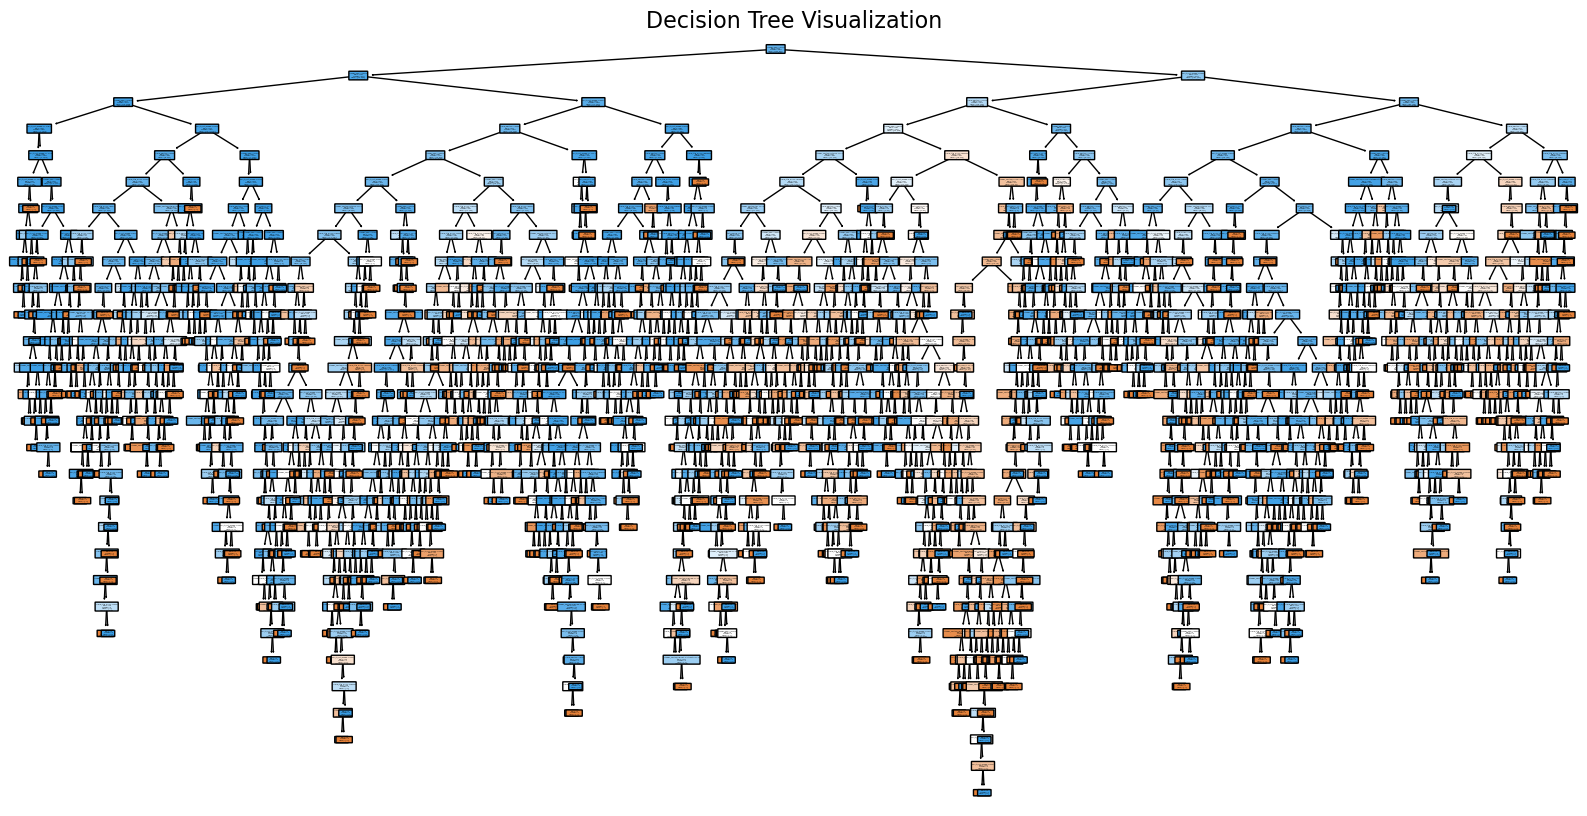

In [9]:
from sklearn.metrics import roc_auc_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

X = df_subset.drop(columns=['is_operating'])
y = df_subset['is_operating']

# One-hot encode 'category_updated' and 'state_code'
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(X[['category_updated', 'state_code']])
encoded_feature_names = encoder.get_feature_names_out(['category_updated', 'state_code'])

# Create a new DataFrame for encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Concatenate the encoded features with the rest of the data
X = pd.concat([X.drop(columns=['category_updated', 'state_code']), encoded_df], axis=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Train a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

# Extract values from confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate TPR and FPR
TPR = TP / (TP + FN)  # True Positive Rate (Recall or Sensitivity)
FPR = FP / (FP + TN)  # False Positive Rate

# Print the metrics
print(f"True Positive Rate (TPR): {TPR:.4f}")
print(f"False Positive Rate (FPR): {FPR:.4f}")

y_proba = clf.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(20, 10))

# Plot the decision tree
plot_tree(clf,
          feature_names=X.columns,   # Use the feature names
          class_names=['Not Operating', 'Operating'],  # Specify target class names
          filled=True,  # Add color to the nodes
          rounded=True)  # Rounded corners for better readability

# Add title
plt.title("Decision Tree Visualization", fontsize=16)

# Show the plot
plt.show()

## Features split in text form

In [11]:
from sklearn.tree import export_text

# Export the tree structure as text
tree_rules = export_text(clf,
                         feature_names=list(X.columns),  # Feature names
                         decimals=3,                    # Number of decimal places
                         show_weights=True)             # Show weighted samples if applicable

# Print the tree splits
print("Decision Tree Rules:\n")
print(tree_rules)

Decision Tree Rules:

|--- company_age <= 5143.500
|   |--- company_age <= 4542.500
|   |   |--- company_age <= 4100.500
|   |   |   |--- days_to_first_funding <= -3005.500
|   |   |   |   |--- weights: [1.000, 0.000] class: 0
|   |   |   |--- days_to_first_funding >  -3005.500
|   |   |   |   |--- days_to_first_funding <= -229.500
|   |   |   |   |   |--- days_to_first_funding <= -244.000
|   |   |   |   |   |   |--- company_age <= 4077.500
|   |   |   |   |   |   |   |--- state_code_MA <= 0.500
|   |   |   |   |   |   |   |   |--- category_updated_Finance <= 0.500
|   |   |   |   |   |   |   |   |   |--- weights: [0.000, 56.000] class: 1
|   |   |   |   |   |   |   |   |--- category_updated_Finance >  0.500
|   |   |   |   |   |   |   |   |   |--- funding_duration <= 105.500
|   |   |   |   |   |   |   |   |   |   |--- weights: [1.000, 0.000] class: 0
|   |   |   |   |   |   |   |   |   |--- funding_duration >  105.500
|   |   |   |   |   |   |   |   |   |   |--- weights: [0.000, 4.0

## Finding the range of ccp values to test

In [13]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.00000000e+00 4.99314734e-05 5.03725893e-05 5.06917819e-05
 6.15053898e-05 6.25136749e-05 6.34904510e-05 6.41587716e-05
 6.54657095e-05 6.55045283e-05 6.57882007e-05 6.60713637e-05
 6.66812532e-05 6.66812532e-05 6.67954334e-05 6.68201725e-05
 6.69789374e-05 6.70102725e-05 6.70869564e-05 6.71813626e-05
 6.72725641e-05 6.72833871e-05 6.73589614e-05 6.77231478e-05
 6.77231478e-05 6.77231478e-05 6.77231478e-05 6.77231478e-05
 6.77231478e-05 7.01242299e-05 7.51904381e-05 7.61885412e-05
 7.61885412e-05 7.61885412e-05 7.61885412e-05 7.61885412e-05
 7.68749245e-05 7.76538239e-05 7.98165670e-05 8.06307774e-05
 8.10895585e-05 8.12677773e-05 8.12677773e-05 8.12677773e-05
 8.12677773e-05 8.12677773e-05 8.19506998e-05 8.23096719e-05
 8.46539347e-05 8.46539347e-05 8.46539347e-05 8.46539347e-05
 8.46539347e-05 8.46539347e-05 8.46539347e-05 8.46539347e-05
 8.46539347e-05 8.46539347e-05 8.70726186e-05 8.70726186e-05
 8.70726186e-05 8.88866315e-05 8.88866315e-05 8.88866315e-05
 8.88866315e-05 8.888663

## Cross Validation with StratifiedKFold and balanced class weights

In [15]:
## Cross Validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

grid_values = {
    'ccp_alpha': [5e-5, 7e-5, 1e-4, 2e-4, 5e-4, 7e-4, 1e-3, 2e-3, 3e-3, 5e-3, 1e-2],
    'min_samples_leaf': [1, 5, 10],
    'min_samples_split': [10, 20, 30],
    'max_depth': [10, 20, 30],
    'random_state': [1337]
}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
clf2 = DecisionTreeClassifier(class_weight='balanced')
clf2_cv = GridSearchCV(clf2, param_grid = grid_values, cv=cv, scoring = 'accuracy', n_jobs=-1)
clf2_cv.fit(X_train, y_train)

best_params = clf2_cv.best_params_
best_score = clf2_cv.best_score_

print("Best Parameters:", best_params)
print("Best Mean Cross-Validated Score:", best_score)

acc = clf2_cv.cv_results_['mean_test_score']
ccp = clf2_cv.cv_results_['param_ccp_alpha'].data

Best Parameters: {'ccp_alpha': 7e-05, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'random_state': 1337}
Best Mean Cross-Validated Score: 0.7512184804589163


In [17]:
ccp_results = pd.DataFrame({'ccp alpha' : ccp, 'Validation Accuracy': acc})
ccp_results.sort_values('Validation Accuracy', ascending=False).head(5)

,ccp alpha,Validation Accuracy
45,0.00007,0.751218
18,0.00005,0.751015
72,0.0001,0.750000
9,0.00005,0.745224
36,0.00007,0.745122


## CV Results

In [19]:
y_pred = clf2_cv.best_estimator_.predict(X_test)

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Extract TN, FP, FN, TP from the confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
TPR = TP / (TP + FN)  # True Positive Rate (Recall/Sensitivity)
FPR = FP / (FP + TN)  # False Positive Rate

# Print results
print(f"\nAccuracy: {accuracy:.4f}")
print(f"True Positive Rate (TPR): {TPR:.4f}")
print(f"False Positive Rate (FPR): {FPR:.4f}")

from sklearn.metrics import roc_auc_score
y_pred_proba = clf2_cv.best_estimator_.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {auc_score:.4f}")

Confusion Matrix:
[[ 227  176]
 [ 458 1601]]

Accuracy: 0.7425
True Positive Rate (TPR): 0.7776
False Positive Rate (FPR): 0.4367
ROC-AUC Score: 0.6816
